## Kinetic Modeling of Repass Pathways for Prenol/Isoprenol production

This work describes a reaction network in which two phosphatases, an isomerase, and a kinase generate C5 alcohols from either IP or IPP. The reaction network has 16 rate constants (Vm/Km) for 8 reactions, 4 substrates, and 2 products.

### Inputs:
- The user will be able to define whether they want to model the OriMVA-Repass or the IPP-Repass
    - The difference is the initial condition of 10 arb. units of IPP or IP, respectively

### Outputs:
- Two .csvs of the pvalues and Spearman rank correlation coefficients of each paramter
- Heatmaps of the pvalues and coefficients
- An example plot of the model given input parameters provided

##### Import Libraries

In [1]:
from scipy.stats import qmc
from scipy.integrate import odeint
from scipy.stats import spearmanr
import matplotlib.pylab as plt
import chart_studio.plotly as py
import numpy as np
import seaborn as sns
import pandas as pd
import os
import plotly.graph_objs as go
from plotly import tools
import array
import warnings
from textwrap import wrap
from matplotlib.font_manager import FontProperties

##### Define Variables 
- Define upper and lower bounds for kinetic parameters
- Define number of LHS iterations
- Make readable for kinetic model

In [2]:
sampler = qmc.LatinHypercube(d=16)
sample = sampler.random(n=10000)
results_list=[]

lb_kcat=0.1       #[s^-1]
ub_kcat=100       #[s^-1]

lb_km=0.1         #[M]
ub_km=100         #[M]

l_bounds=[lb_kcat]*8
u_bounds=[ub_kcat]*8
l_bounds_km=[lb_km]*8
u_bounds_km=[ub_km]*8

l_bounds.extend(l_bounds_km)
u_bounds.extend(u_bounds_km)

A=qmc.discrepancy(sample)
B=qmc.scale(sample, l_bounds, u_bounds)
LHS=np.transpose(B)
num_iterations=LHS.shape[1]

### First-order kinetic model

- Here the initial condition is set to 1 arb. unit of either IPP or IP depending on the selected pathy
- Time set to 150 arb. unit with a sampling of n = 100
    - Time and sampling may be changed, these were set because most simulations reach steady-state

In [3]:
def get_user_choice():
    print("Please choose a Repass pathway configuration:")
    print("1: Original MVA Repass Pathway")
    print("2: IPP-Repass Pathway")

    while True:
        choice = input("Enter 1 or 2: ")
        if choice == '1':
            pathway = 1
            return pathway, "You chose Original MVA Repass Pathway"
        elif choice == '2':
            pathway = 2
            return pathway, "You chose IPP-Repass Pathway"
        else:
            print("Invalid input. Please enter 1 or 2.")

# Call the function and print the result
pathway, result = get_user_choice()
print(result)

Please choose a Repass pathway configuration:
1: Original MVA Repass Pathway
2: IPP-Repass Pathway


Enter 1 or 2:  2


You chose IPP-Repass Pathway


In [4]:
print("Running simulation {} times".format(num_iterations))
for j in range (0,num_iterations):
    def model(y,t):
        x1 = y[0]
        x2 = y[1]
        x3 = y[2]
        x4 = y[3]
        x5 = y[4]
        x6 = y[5]
        
        x7=LHS[0,j]
        x8=LHS[1,j]
        x9=LHS[2,j]
        x10=LHS[3,j]
        x11=LHS[4,j]
        x12=LHS[5,j]
        x13=LHS[6,j]
        x14=LHS[7,j]
        
        x15=LHS[8,j]
        x16=LHS[9,j]
        x17=LHS[10,j]
        x18=LHS[11,j]
        x19=LHS[12,j]
        x20=LHS[13,j]
        x21=LHS[14,j]
        x22=LHS[15,j]
        
        # k3/k4 magnitude favors DMAPP>IPP by isomerase
        # k7/k2 magntiude favors DMAP>IP by phosphatase
        # k6/k1 magnitude favors DMAPP>IPP by kinase
        # k8/K4 magnitude favors prenol>isoprenol
        
        k1 = x7/(x15+x1)  # IP -> IPP
        k2 = x8/(x16+x3)  # IPP -> IP
        k3 = x9/(x17+x4)  # DMAPP -> IPP
        k4 = x10/(x18+x3) # IPP -> DMAPP

        k5 = x11/(x19+x1) # IP -> Isoprenol
        k6 = x12/(x20+x5) # DMAP -> DMAPP
        k7 = x13/(x21+x4) # DMAPP -> DMAP
        k8 = x14/(x22+x5) # DMAP -> Prenol

        dy1dt=-k1*x1-k5*x1+k2*x3 #IP
        dy2dt=k5*x1 #Isoprenol
        dy3dt=k1*x1+k3*x4-k4*x3-k2*x3 #IPP
        dy4dt=k4*x3+k6*x5-k3*x4-k7*x4 #DMAPP
        dy5dt=k7*x4-k6*x5-k8*x5 #DMAP
        dy6dt=k8*x5 #Prenol

        dydt = [dy1dt,dy2dt,dy3dt,dy4dt,dy5dt,dy6dt]
        return dydt
    
    if pathway ==1:
        y0 = [0,0,10,0,0,0]
    else:
        y0 = [10,0,0,0,0,0]

    n = 100
    culture_time=150

    # time points
    t = np.linspace(0,culture_time,n)

    # store solution
    x1 = np.empty_like(t)
    x2 = np.empty_like(t)
    x3 = np.empty_like(t)
    x4 = np.empty_like(t)
    x5 = np.empty_like(t)
    x6 = np.empty_like(t)

    # record initial conditions
    x1[0] = y0[0]
    x2[0] = y0[1]
    x3[0] = y0[2]
    x4[0] = y0[3]
    x5[0] = y0[4]
    x6[0] = y0[5]

    # solve ODE
    for i in range(1,n):
        # span for next time step
        tspan = [t[i-1],t[i]]
        # solve for next step
        y = odeint(model,y0,tspan)
        # store solution for plotting
        x1[i] = y[1][0]
        x2[i] = y[1][1]
        x3[i] = y[1][2]
        x4[i] = y[1][3]
        x5[i] = y[1][4]
        x6[i] = y[1][5]
        
        # next initial condition
        y0 = y[1]
        
        ##enter in other results of interest
        #results=[x2[n-1],x6[n-1], max(x1),np.mean(x3),max(x5),max(x4)]
        results=[x2[n-1],x6[n-1]]

    # plot results
    results_list.append(results)
    if j % (0.1*num_iterations) == 0:
        percentj=100*(j/num_iterations)
        print(percentj, " %")
        
print("Done")

Running simulation 10000 times
0.0  %


C:\Users\Carruthers\AppData\Local\Temp\ipykernel_28052\960277054.py:86: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.



10.0  %
20.0  %
30.0  %
40.0  %
50.0  %
60.0  %
70.0  %
80.0  %
90.0  %
Done


##### Bifurcation of alcohols as a ratio of prenol to isoprenol (arb. units)

In [5]:
column_index = 0  
column_index2 = 1 

column_values = [row[column_index] for row in results_list]
column_values2 = [row[column_index2] for row in results_list]

mean_value = sum(column_values) / len(column_values)
mean_value2 = sum(column_values2) / len(column_values2)
prenol_frac= mean_value2/(mean_value+mean_value2)
ratio = mean_value2/mean_value
print(f"Ratio of prenol to isoprenol across all LHS conditions: {ratio}")
print(f"Prenol as a fraction of total alcohols: {prenol_frac}")

Ratio of prenol to isoprenol across all LHS conditions: 0.3202063146859164
Prenol as a fraction of total alcohols: 0.24254263225675834


### Repass Sensitivity

- Provides the Spearmans rank correlation coefficients and their associated p-values
- Plots heatmaps and saving as .csv files

In [6]:
if pathway ==1:
    fig='OriMVA-Repass_Sensitivity'
else:
    fig='IPP-Repass_Sensitivity'

outputs_names=['Isoprenol','Prenol']
inputs_names=['$k_{cat_{1}}^{*}$','$k_{cat_{2}}^{*}$','$k_{cat_{3}}^{*}$','$k_{cat_{4}}^{*}$',
              '$k_{cat_{5}}^{*}$','$k_{cat_{6}}^{*}$','$k_{cat_{7}}^{*}$','$k_{cat_{8}}^{*}$',
              '$K_{m_{1}}$','$K_{m_{2}}$','$K_{m_{3}}$','$K_{m_{4}}$','$K_{m_{5}}$','$K_{m_{6}}$','$K_{m_{7}}$','$K_{m_{8}}$']

results_list_Repass=np.array(results_list)
LHS=np.transpose(np.array(LHS))

inputs=16
outputs=2
rho_list = []
rho_list=np.zeros((inputs,outputs))
pval_list=[]
pval_list=np.zeros((inputs,outputs))

for m in range(outputs):
    for k in range(inputs):
        rho_list[k,m],pval_list[k,m]=spearmanr(LHS[:,k],results_list_Repass[:,m], axis=1) 
        

In [7]:
df_rho = pd.DataFrame(rho_list)
df_pval = pd.DataFrame(pval_list)

rho_path=f'{fig}_Rhos.csv'
pval_path=f'{fig}_Pvals.csv'

df_rho.to_csv(f'Figure_Export/{rho_path}', index=False, header=False)
df_pval.to_csv(f'Figure_Export/{pval_path}', index=False, header=False)

#### Plotting a heatmap of Spearman rank correlation coefficient

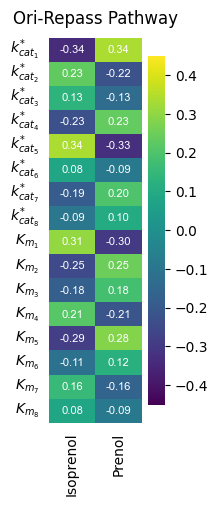

In [8]:
plt.figure(figsize=(1.5,5))
vmin_value = -0.45  # Minimum value
vmax_value = 0.45  # Maximum value

p1 = sns.heatmap(rho_list, cmap='viridis',vmin=vmin_value, vmax=vmax_value,
                 xticklabels=outputs_names, yticklabels=inputs_names, annot_kws={"size": 8,"fontfamily": "Arial"})
# Annotate all values
for i in range(len(inputs_names)):
    for j in range(len(outputs_names)):
        p1.text(j + 0.5, i + 0.5, f'{rho_list[i, j]:.2f}', ha='center', va='center', color='white',fontsize=8, fontfamily="Arial")

plt.yticks(rotation='horizontal')
plt.title('Ori-Repass Pathway',pad=10)        
        
plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.tick_params(axis='y', which='both', left=False, right=False)

plt.savefig(f'Figure_Export/{fig}_Rhos.svg',dpi=1200, bbox_inches = 'tight')
plt.show()

#### Plotting a heatmap of p-values

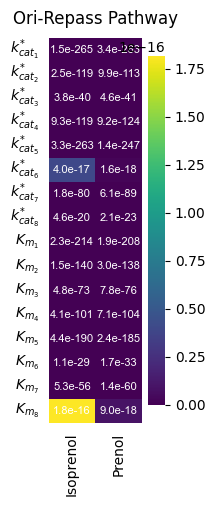

In [9]:
plt.figure(figsize=(1.5,5))
p2 = sns.heatmap(pval_list, cmap='viridis', xticklabels=outputs_names, yticklabels=inputs_names, 
                 annot_kws={"size": 8,"fontfamily": "Arial"})
for i in range(len(inputs_names)):
    for j in range(len(outputs_names)):
        p2.text(j + 0.5, i + 0.5, f'{pval_list[i, j]:.1e}', ha='center', va='center', color='white',fontsize=8, fontfamily="Arial")
plt.yticks(rotation='horizontal')
plt.title('Ori-Repass Pathway',pad=10)        
        
plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.tick_params(axis='y', which='both', left=False, right=False)

plt.savefig(f'Figure_Export/{fig}_Pvals.svg',dpi=1200, bbox_inches = 'tight')
plt.show()

### Example plot of a selected pathway

Here, an example pathway depicts profiles of given reaction productions. The pathway can be adjusted by manually defining the Vmx/Kmx values as well as changing the model to the IPP-Repass as follows:

- Original MVA-Repass:
    - fig='OriMVA'
    - y0 = [0,0,10,0,0,0]
- To change to IPP-Repass:
    - fig='IPPRe'
    - y0 = [10,0,0,0,0,0]
- Parameters may be changed at will
    

In [10]:
if pathway ==1:
    fig='OriMVA-Repass_Example'
    y0 = [0,0,10,0,0,0]
else:
    fig='IPP-Repass_Example'
    y0 = [10,0,0,0,0,0]
    
#Define variables as x1, x2, x3, x4, x5, x6
def model(y,t):
    x1 = y[0]
    x2 = y[1]
    x3 = y[2]
    x4 = y[3]
    x5 = y[4]
    x6 = y[5]
    
    k1 = Vm1/(Km1+x1) #IP to IPP
    k2 = Vm2/(Km2+x3) #IPP to IP
    k3 = Vm3/(Km3+x4) #IPP to DMAPP
    k4 = Vm4/(Km4+x3) #DMAPP to IPP
    k5 = Vm5/(Km5+x1) #IP to isoprenol
    k6 = Vm6/(Km6+x5) #DMAP to DMAPP
    k7 = Vm7/(Km7+x4) #DMAPP to DMAP
    k8 = Vm8/(Km8+x5) #DMAP to prenol

    dy1dt=-k1*x1-k5*x1+k2*x3 #IP
    dy2dt=k5*x1 #Isoprenol
    dy3dt=k1*x1+k3*x4-k4*x3-k2*x3 #IPP
    dy4dt=k4*x3+k6*x5-k3*x4-k7*x4 #DMAPP
    dy5dt=k7*x4-k6*x5-k8*x5 #DMAP
    dy6dt=k8*x5 #Prenol

    dydt = [dy1dt,dy2dt,dy3dt,dy4dt,dy5dt,dy6dt]
    return dydt

# initial condition
   
Vm1=10
Vm2=10
Vm3=20
Vm4=20
Vm5=10
Vm6=10
Vm7=10
Vm8=10

Km1=20
Km2=20
Km3=40
Km4=40
Km5=20
Km6=200
Km7=20
Km8=200

# number of time points
n = 100

# time points
t = np.linspace(0,72,n)

# store solution
x1 = np.empty_like(t)
x2 = np.empty_like(t)
x3 = np.empty_like(t)
x4 = np.empty_like(t)
x5 = np.empty_like(t)
x6 = np.empty_like(t)

# record initial conditions
x1[0] = y0[0]
x2[0] = y0[1]
x3[0] = y0[2]
x4[0] = y0[3]
x5[0] = y0[4]
x6[0] = y0[5]

# solve ODE
for i in range(1,n):
    # span for next time step
    tspan = [t[i-1],t[i]]
    # solve for next step
    y = odeint(model,y0,tspan)
    # store solution for plotting
    x1[i] = y[1][0]
    x2[i] = y[1][1]
    x3[i] = y[1][2]
    x4[i] = y[1][3]
    x5[i] = y[1][4]
    x6[i] = y[1][5]
    # next initial condition
    y0 = y[1]
results=[x1[n-1],x2[n-1],x3[n-1],x4[n-1],x5[n-1],x6[n-1]]

#### Plotting and saving the figure

- Parameters customized for publication quality figure
- Color values set according to (https://davidmathlogic.com/colorblind)

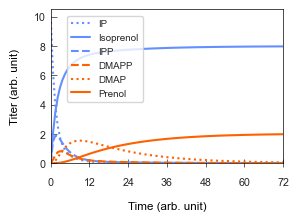

In [11]:
plt.figure(figsize=(3,2))
color_values = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000'] 

line_size=0.5
custom_params = {
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.grid': False,
    'axes.axisbelow': 'line',
    'axes.labelcolor': 'black',
    'figure.facecolor': 'white',
    "axes.spines.right": True, 
    "axes.spines.bottom": True,
    'xtick.direction': 'inout',
    'ytick.direction': 'in',
    'xtick.bottom': True,
    'xtick.minor.visible': False,
    'xtick.major.bottom':  True,
    'xtick.minor.bottom':  True,
    'xtick.major.pad':     7,     # distance to major tick label in points#
    'xtick.minor.pad':     3.4,     # distance to the minor tick label in points#
    'xtick.major.size':    10,
    'ytick.major.size':    4,
    'xtick.major.width':   line_size,
    'ytick.major.width':   line_size,
    'axes.linewidth': line_size,
    'xtick.minor.size':    2,
    'pdf.fonttype': 42}

sns.set_theme(style="ticks", rc=custom_params, font="Arial",font_scale=0.7)

# plot results
plt.plot(t,x1,color=color_values[0], linestyle=':',label='IP',linewidth=1.5)
plt.plot(t,x2,color=color_values[0], linestyle='-',label='Isoprenol',linewidth=1.5)
plt.plot(t,x3,color=color_values[0], linestyle='--',label='IPP',linewidth=1.5)
plt.plot(t,x4,color=color_values[3], linestyle='--',label='DMAPP',linewidth=1.5)
plt.plot(t,x5,color=color_values[3], linestyle=':',label='DMAP',linewidth=1.5)
plt.plot(t,x6,color=color_values[3], linestyle='-',label='Prenol',linewidth=1.5)
plt.ylabel('values')
plt.xlabel('time')
plt.legend(loc='upper left',bbox_to_anchor=(0.05, 0.99),fontsize="7")
plt.ylim(0,None)
plt.xlim(0,72)
#plt.title('IPK Recursion Kinetic Model')
plt.xlabel('Time (arb. unit)', labelpad=10)
plt.ylabel('Titer (arb. unit)', labelpad=10)

plt.tick_params(axis='x', which='both', length=6) 
plt.xticks(range(0,80,12))
              
plt.savefig(f'Figure_Export/{fig}_Kinetic_Model.svg',dpi=1200, bbox_inches = 'tight')
plt.show()